In [111]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # for splitting the training data

from xgboost import XGBRegressor

# for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
Kfold_validation = KFold(10) # use k=5 for cross validation

# Calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load and validate the training and testing data

In [107]:
# Load the preprocessed training data
train_processed = pd.read_csv('train_processed.csv')
print("Training data shape:", train_processed.shape)
print("Columns:", train_processed.columns.tolist())

# Separate features (X) and target (y)
y_train = train_processed['Price']
X_train = train_processed.drop(columns=['Price'])


print(f"\nFeatures shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"\nTarget statistics:")
print(f"Mean price: {y_train.mean():.2f}")
print(f"Min price: {y_train.min():.2f}")
print(f"Max price: {y_train.max():.2f}")

# Split data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.005, random_state=15
)
print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")

Training data shape: (4336, 21)
Columns: ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'No. of Doors', 'Price', 'Age', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Fuel_Type_CNG', 'Fuel_Type_LPG', 'Transmission_Manual', 'Transmission_Automatic', 'Owner_Type_First', 'Owner_Type_Second', 'Owner_Type_Third', 'Owner_Type_Fourth & Above', 'Colour_Others', 'Colour_Black/Silver', 'Colour_White']

Features shape: (4336, 20)
Target shape: (4336,)

Target statistics:
Mean price: 9.65
Min price: 0.44
Max price: 160.00
Training set: (4314, 20)
Validation set: (22, 20)


# XGBoost Regressor model

In [114]:
# Train an XGBoost Regressor model with optimal parameters from CV
print("Training XGBoost model...")
xgb_model = XGBRegressor(
    # Tree Structure
    n_estimators=200,           # Optimal from xgb.cv() - was 2000
    max_depth=15,                # Maximum tree depth
    
    # Learning Parameters
    learning_rate=0.1,         # Step size shrinkage (lower = more conservative)
    subsample=0.8,              # Row sampling ratio per tree
    colsample_bytree=1.0,       # Column (feature) sampling per tree - like max_features
    colsample_bylevel=1.0,      # Column sampling per tree level
    colsample_bynode=1.0,       # Column sampling per node split
    
    # Performance & Evaluation
    tree_method='auto',         # Histogram-based algorithm
    eval_metric='mape',         # Use MAPE as evaluation metric
    n_jobs=-1,                  # Use all CPU cores
    random_state=42,
    verbosity=1                 # Print messages
)

xgb_model.fit(
    X_train_split, 
    y_train_split,
    verbose=True               # Set to True to see training progress
)

# Make predictions
y_pred_train_xgb = xgb_model.predict(X_train_split)
y_pred_val_xgb = xgb_model.predict(X_val)

# Evaluate the model
print("\n=== XGBoost Model Performance ===")
print(f"Training MAPE: {calculate_mape(y_train_split, y_pred_train_xgb):.2f}%")
print(f"Validation MAPE: {calculate_mape(y_val, y_pred_val_xgb):.2f}%")

# check the cross validation with MAPE scoring


# Create custom MAPE scorer (negative because lower is better)
mape_scorer = make_scorer(
    lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
    greater_is_better=False  # Lower MAPE is better
)

xgb_model_cross_validation_result = cross_val_score(
    xgb_model, 
    X_train, 
    y_train, 
    cv=Kfold_validation,
    scoring=mape_scorer,
    n_jobs=-1  # Parallel processing
)

print("\n=== Cross validation result (MAPE) ===")
print(-xgb_model_cross_validation_result)  # Negate to show actual MAPE values
print("\n=== Cross validation mean MAPE ===")
print(f"{-np.mean(xgb_model_cross_validation_result):.2f}%")


Training XGBoost model...

=== XGBoost Model Performance ===
Training MAPE: 0.36%
Validation MAPE: 18.45%

=== XGBoost Model Performance ===
Training MAPE: 0.36%
Validation MAPE: 18.45%

=== Cross validation result (MAPE) ===
[19.53092492 17.22753722 26.28215955 17.60590441 18.95530781 19.50148507
 18.71826779 18.30408944 17.32762195 18.52448851]

=== Cross validation mean MAPE ===
19.20%

=== Cross validation result (MAPE) ===
[19.53092492 17.22753722 26.28215955 17.60590441 18.95530781 19.50148507
 18.71826779 18.30408944 17.32762195 18.52448851]

=== Cross validation mean MAPE ===
19.20%


## Optional: XGBoost Built-in Cross-Validation

In [ ]:
# # XGBoost built-in cross-validation (more efficient than sklearn's cross_val_score)
# import xgboost as xgb

# # Convert data to DMatrix format (XGBoost's internal data structure)
# dtrain = xgb.DMatrix(X_train, label=y_train)

# # Define parameters
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'mape',
#     'max_depth': 7,
#     'learning_rate': 0.05,
#     'subsample': 0.8,
#     'colsample_bytree': 1.0,
#     'min_child_weight': 1,
#     'tree_method': 'auto',
#     'seed': 10
# }

# # Run cross-validation with early stopping
# cv_results = xgb.cv(
#     params=params,
#     dtrain=dtrain,
#     num_boost_round=2000,      # Maximum number of trees
#     nfold=10,                   # Number of CV folds
#     metrics='mape',             # Evaluation metric
#     early_stopping_rounds=50,   # Stop if no improvement
#     verbose_eval=50,            # Print every 50 rounds
#     seed=10
# )

# print("\n=== XGBoost CV Results ===")
# print(f"Best iteration: {len(cv_results)}")
# print(f"Best CV MAPE: {cv_results['test-mape-mean'].min():.2f}%")
# print(f"Train MAPE: {cv_results['train-mape-mean'].iloc[-1]:.2f}%")

# # Train final model with optimal n_estimators
# optimal_rounds = len(cv_results)
# print(f"\nTraining final model with {optimal_rounds} trees...")

# Load test data set

In [109]:
# Load test_processed.csv and predict the price
test_processed = pd.read_csv('test_processed.csv')
print("Test data shape:", test_processed.shape)
print("Test data columns:", test_processed.columns.tolist())

# Save ID column if it exists
X_test = test_processed.drop(columns=['ID'])

print(f"\nTest features shape: {X_test.shape}")
print(f"Training features shape: {X_train.shape}")

# Verify columns match between train and test
print(f"\nColumns match: {list(X_train.columns) == list(X_test.columns)}")

Test data shape: (1491, 21)
Test data columns: ['ID', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'No. of Doors', 'Age', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Fuel_Type_CNG', 'Fuel_Type_LPG', 'Transmission_Manual', 'Transmission_Automatic', 'Owner_Type_First', 'Owner_Type_Second', 'Owner_Type_Third', 'Owner_Type_Fourth & Above', 'Colour_Others', 'Colour_Black/Silver', 'Colour_White']

Test features shape: (1491, 20)
Training features shape: (4336, 20)

Columns match: True


# Perform Prediction on test data set and save to a submission file

In [ ]:
# Make predictions on test data using XGBoost
y_pred_xgb = xgb_model.predict(X_test)

print("=== XGBoost Predictions ===")
print(f"Predicted prices - Min: {y_pred_xgb.min():.2f}, Max: {y_pred_xgb.max():.2f}, Mean: {y_pred_xgb.mean():.2f}")

# Save ID and predicted Price to CSV file
submission_xgb = pd.DataFrame({
    'ID': test_processed['ID'],
    'Price': y_pred_xgb
})

submission_xgb.to_csv('submission_xgboost.csv', index=False)
print("\nXGBoost submission saved as 'submission_xgboost.csv'")



=== Top 15 Most Important Features (XGBoost) ===
            feature  importance
              Power    0.535411
              Seats    0.116080
                Age    0.110021
Transmission_Manual    0.072583
   Fuel_Type_Diesel    0.054370
             Engine    0.042908
       Colour_White    0.012393
            Mileage    0.009907
  Kilometers_Driven    0.008926
   Owner_Type_First    0.007694
       No. of Doors    0.007503
      Colour_Others    0.006423
Colour_Black/Silver    0.005325
  Owner_Type_Second    0.004275
   Owner_Type_Third    0.004256


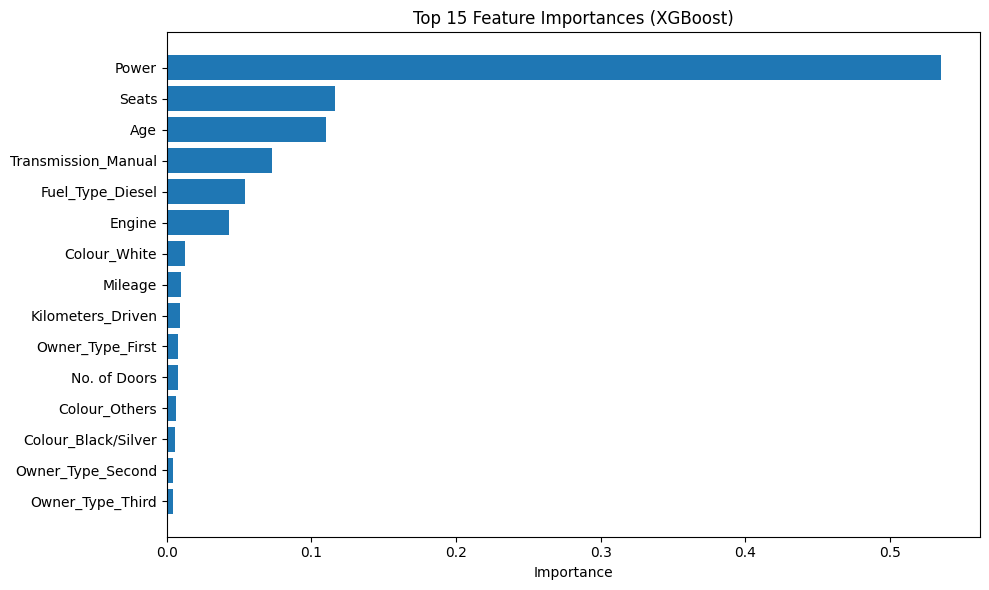

In [110]:
# Feature importance from XGBoost
import matplotlib.pyplot as plt

feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 15 Most Important Features (XGBoost) ===")
print(feature_importance_xgb.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb.head(15)['feature'], feature_importance_xgb.head(15)['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()